# Time Series Analysis

In [1]:
# suppress one small warning
import warnings

# base libraries
import pandas as pd
import numpy as np

# data visualisations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# connect to db
import psycopg2

# type hints for functions
from typing import Optional

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

from rich.console import Console

register_matplotlib_converters()
console = Console()

# set settings for seaborn
sns.set_style(style="whitegrid", rc={"grid.color": ".9"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
title_font = {"fontname": "DejaVu Sans Mono"}

# establish connection with the database
conn = psycopg2.connect("dbname=bikemi user=luca")

The cluster table is uploaded to the local database using a Bash script that calls PostgreSQL's `psql` under the hood. Then, this table is `JOIN`-ed with the `MATERIALIZED VIEW` with hourly rentals to create a new `MATERIALIZED VIEW`, that aggregates the individual station time series to the Traffic Analysis Zone level.

The resulting data is an instance of the so-called "long" or panel data format, with 18632 rows for each of the 46 time series. The number is actually smaller it would be if we had three years of hourly observations, because as the service is not active between midnight and 7 a.m.: in other words, these series have 'holes'.

In [2]:
def get_hourly_data(connection, wide: bool = False) -> pd.DataFrame:
    query: str = """
        SELECT
            h.data_partenza,
            h.cluster,
            h.noleggi_per_ora
        FROM bikemi_rentals.clusters_hourly_rentals h;
    """

    if not wide:
        return pd.read_sql(query, connection)
    return (
        pd.read_sql(query, connection)
            .pivot(index="data_partenza", columns="cluster", values="noleggi_per_ora")
    )


get_hourly_data(conn, wide=True).iloc[:5, :5]

cluster,0,1,2,3,4
data_partenza,,,,,
2015-06-01 07:00:00,1,11,0,8,21
2015-06-01 08:00:00,2,9,6,6,10
2015-06-01 09:00:00,3,8,11,16,9
2015-06-01 10:00:00,2,6,18,6,19
2015-06-01 11:00:00,5,15,19,16,12


The cluster labels are just a range of integers, which the overall interpretability. The issue is quickly solved by creating a small function that assigns a new identifier to the cluster, simply by merging the cluster label with the neighbourhood it is located in.

In [3]:
def get_clusters(connection) -> pd.DataFrame:
    query: str = """
        SELECT DISTINCT
            c.cluster,
            c.cluster_nil
        FROM bikemi_rentals.bikemi_clustered_stalls c
        ORDER BY c.cluster
    """

    return pd.read_sql(query, connection).set_index("cluster")


clusters: pd.DataFrame = get_clusters(conn)

clusters.head()

,cluster_nil
cluster,
0,FARINI
1,PORTA TICINESE - CONCHETTA
2,DUOMO
3,PAGANO
4,GIARDINI P.TA VENEZIA


In [4]:
def rename_clusters(
        data: pd.DataFrame,
        clusters_data: pd.DataFrame,
        names_col: str,
        cluster_col: Optional[str] = None,
        suffix: str = "id"
) -> pd.DataFrame:
    df: pd.DataFrame = data.copy()

    def new_cluster_names(
            _clusters_data: pd.DataFrame,
            _names_col: str,
            _clusters_col: Optional[str] = None,
            _suffix: str = "id",
    ) -> list[str]:
        if not _clusters_col:
            return (
                _clusters_data[_names_col]
                    .astype("str")
                    .str.title()
                    .str.cat(_clusters_data.index.astype(str), sep=" - ")
            )

        return (
            _clusters_data[_names_col]
                .astype("str")
                .str.title()
                .str.cat(_clusters_data[_clusters_col].astype(str), sep=" - ")
                .to_list()
        )

    df.columns = new_cluster_names(clusters_data, names_col, cluster_col, suffix)

    return df


def sort_cols(data) -> pd.DataFrame:
    return data.filter(data.columns.sort_values())


hourly_rentals: pd.DataFrame = (
    get_hourly_data(conn, wide=True)
        .pipe(rename_clusters, clusters, "cluster_nil")
        .pipe(sort_cols)
)

hourly_rentals.iloc[:5, :3]

cluster_nil,Brera - 25,Brera - 26,Brera - 43
data_partenza,,,
2015-06-01 07:00:00,7,7,12
2015-06-01 08:00:00,11,5,9
2015-06-01 09:00:00,6,9,13
2015-06-01 10:00:00,11,7,8
2015-06-01 11:00:00,16,14,11


## Time Series Analysis

Visualising high-dimensionality datasets can be quite a challenge, which will also represent itself in when fitting the models. As a shortcut, we can compare the TAZ series inside the same NIL to spot different patterns that might occur.

We choose to visualise data throughout the month of October 2016, as the demand is generally higher in autumn, and this should highlight different seasonality patterns better. October 1st, 2016 starts as a Saturday and it is immediate to see that peak hours are around lunchtime. During weekdays, the distribution seems bimodal, with a smaller peak in the mornings.

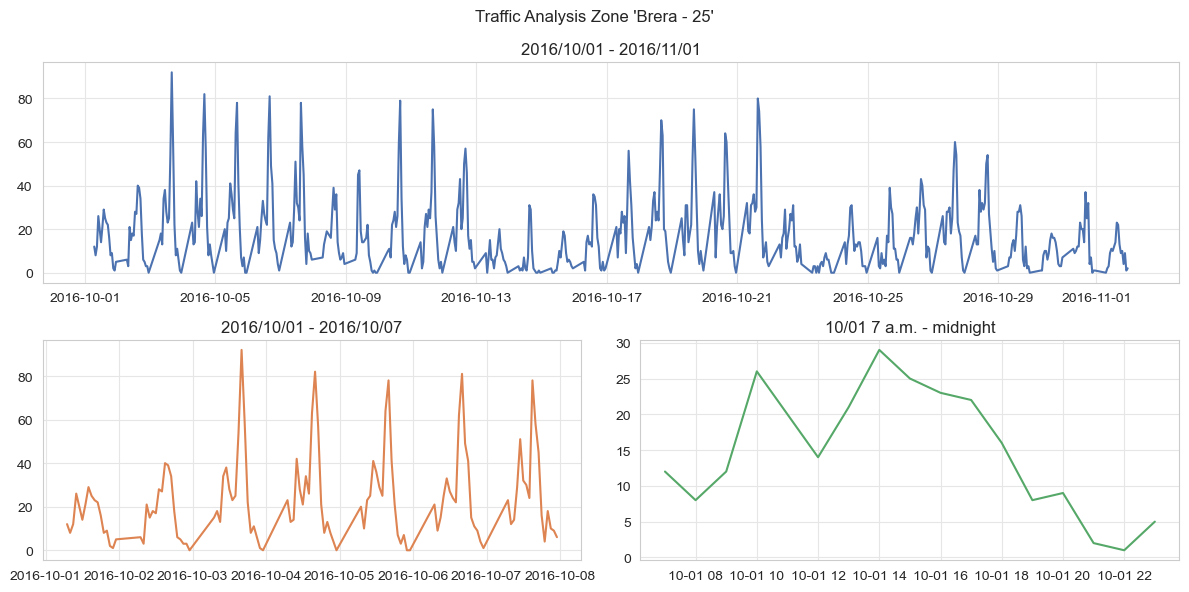

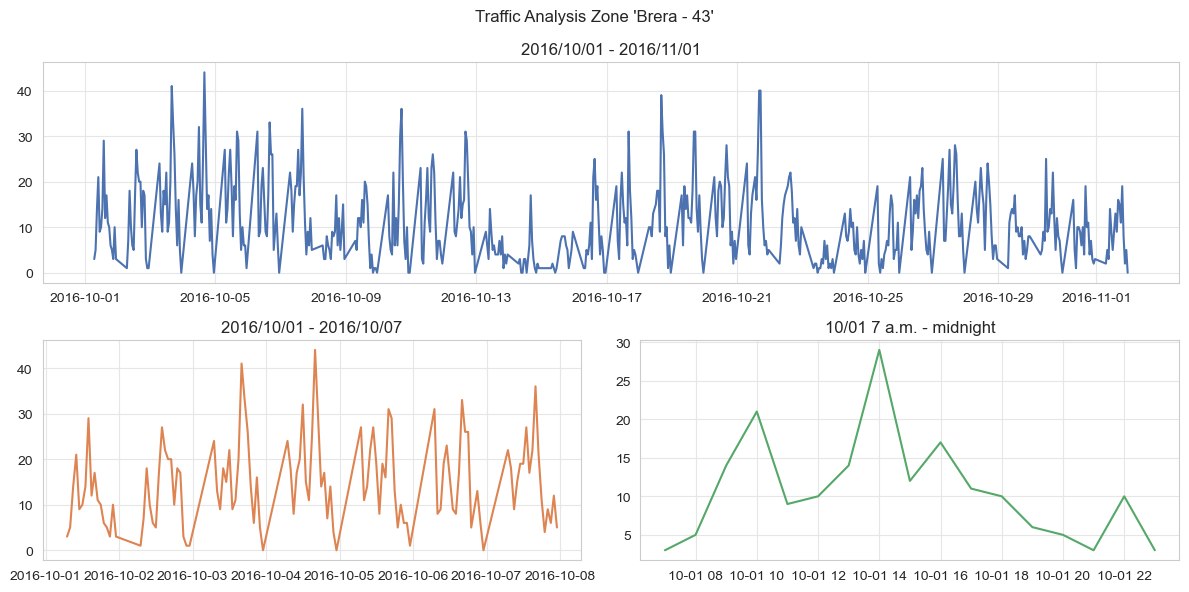

In [5]:
def plot_series(data: pd.DataFrame, series: str) -> None:
    fig = plt.figure(tight_layout=True)
    fig.suptitle(f"Traffic Analysis Zone '{series}'")
    gs = gridspec.GridSpec(2, 2)

    main_ax = fig.add_subplot(gs[0, :])
    main_ax.plot(data.loc["2016-10-01": "2016-11-01", series])
    main_ax.set(title="2016/10/01 - 2016/11/01", xlabel="")

    left_ax = fig.add_subplot(gs[1, 0])
    left_ax.plot(data.loc["2016-10-01": "2016-10-07", series], c=sns_c[1])
    left_ax.set(title="2016/10/01 - 2016/10/07", xlabel="")

    right_ax = fig.add_subplot(gs[1, 1])
    right_ax.plot(data.loc["2016-10-01 07:00": "2016-10-02 00:00", series], c=sns_c[2])
    right_ax.set(title="10/01 7 a.m. - midnight", xlabel="")

    plt.show()


hourly_rentals.pipe(plot_series, "Brera - 25")
hourly_rentals.pipe(plot_series, "Brera - 43")

Data in `Brera` TAZs is quite similar: this is because all stations in Brera are all above the average, when ranking the clusters by absolute number of rentals across the observed time period:

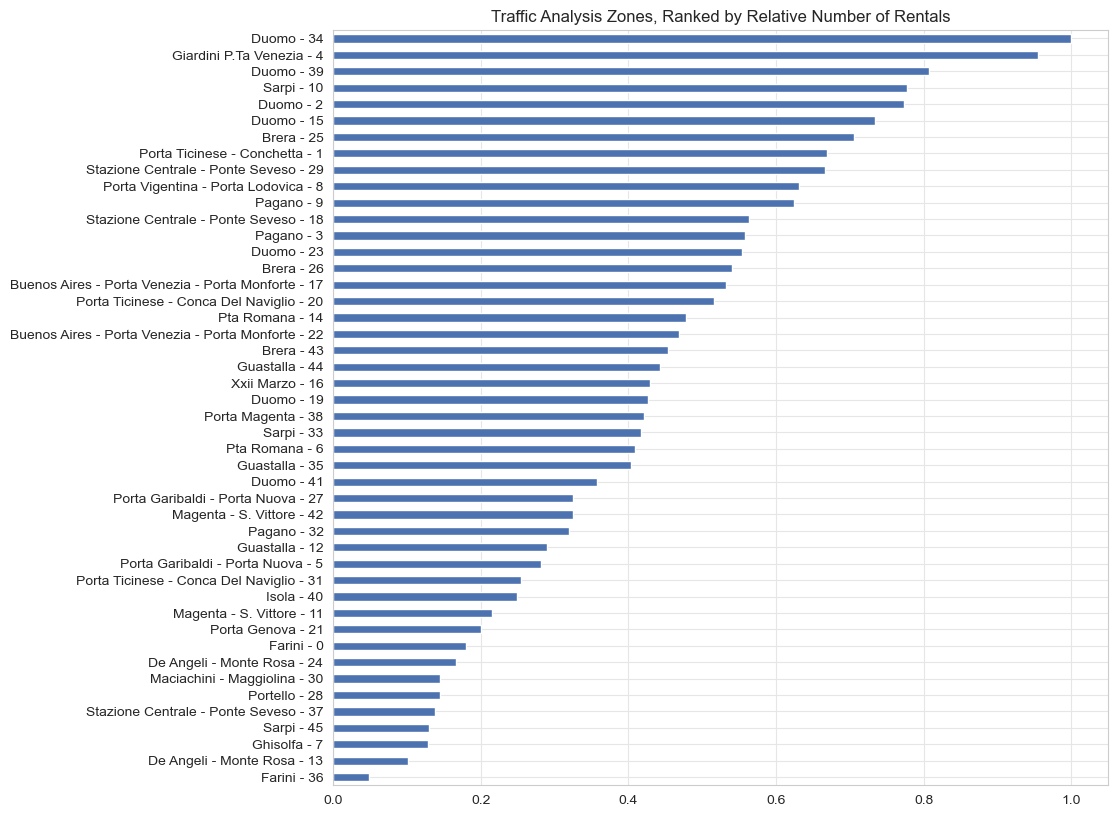

In [6]:
def get_nil(data) -> pd.Series:
    tmp = data.index.str.extract(r'(.*)(\s-\s\d*)$', expand=True)[0]

    tmp.index = data.index

    return tmp


taz_rankings = (
    hourly_rentals
        .apply(sum, axis=0)
        .sort_values(ascending=False)
        .rename("total_rentals")
        .pipe(pd.DataFrame)
        .assign(nil=lambda df: df.pipe(get_nil),
                total_rentals=lambda df: df.total_rentals / max(df.total_rentals)
                )
)


def plot_absolute_ranking() -> None:
    fig, ax = plt.subplots(figsize=(10, 10))

    taz_rankings.plot.barh(xlabel="",
                           ax=ax,
                           legend="",
                           title="Traffic Analysis Zones, Ranked by Relative Number of Rentals")
    ax.invert_yaxis()
    plt.show()


plot_absolute_ranking()

Some different patterns can be seen in, for example, in the NIL `Porta Ticinese - Conca Del Naviglio` the two TAZ `20` and `31`, or between `Stazione Centrale - Ponte Seveso` number `18` and `37`. The first Traffic Analysis Zone in these areas is always in the top of the ladder, while the second is closer to the tail, and as such the demand in the two clusters behaves differently: in number `20`, during weekdays the two modes appear to be much closer to each other, while in `31` it is not unusual for the morning peak to be greater.

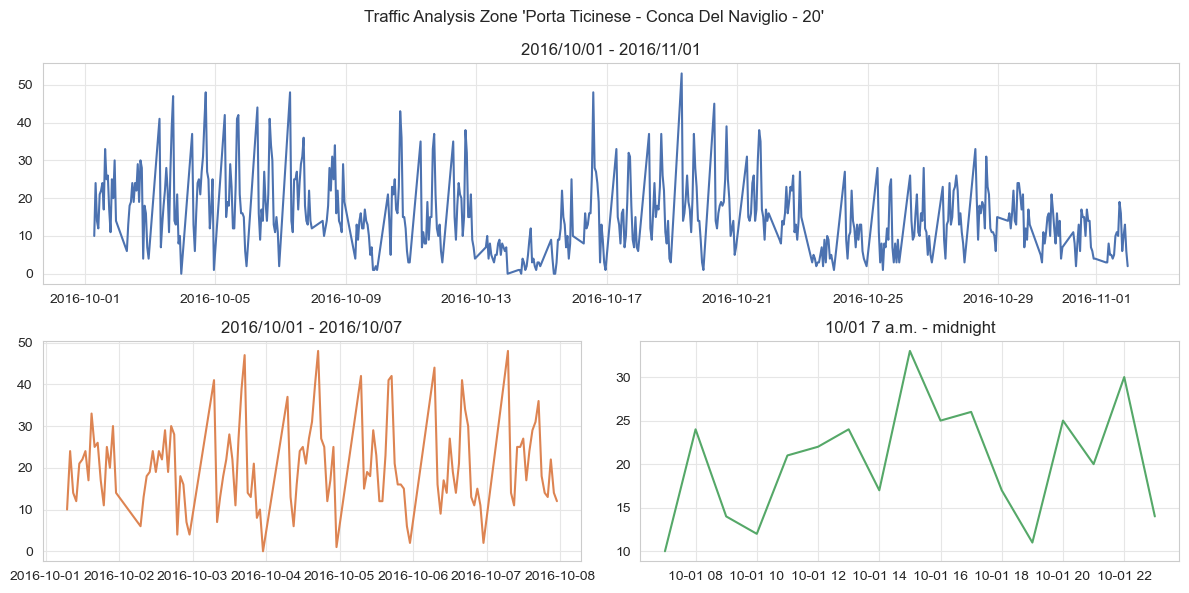

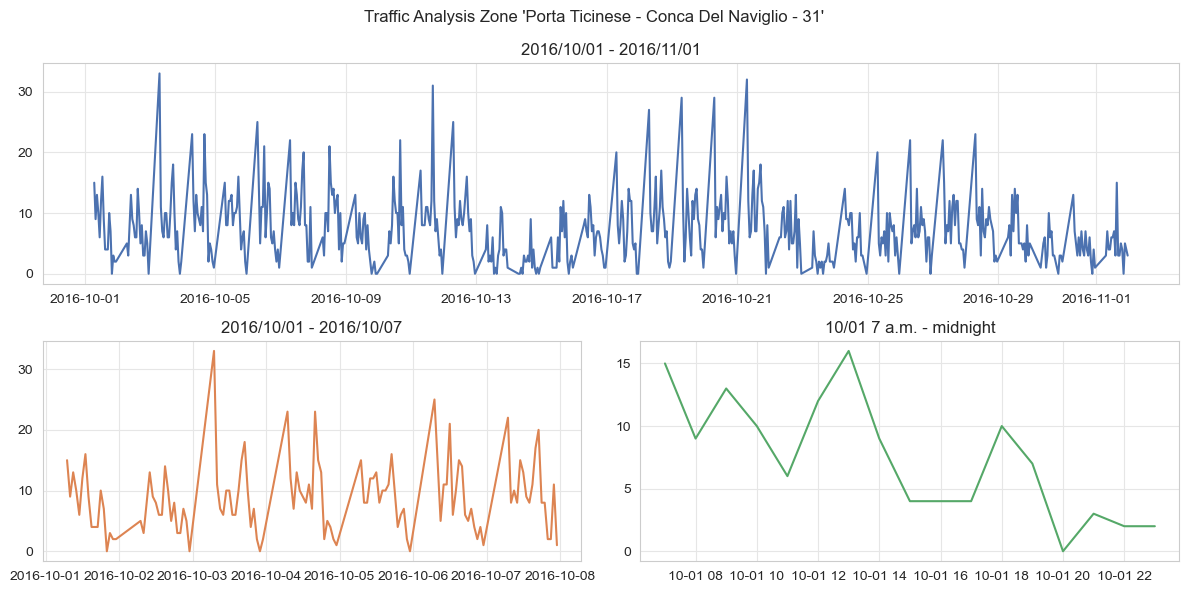

In [7]:
hourly_rentals.pipe(plot_series, "Porta Ticinese - Conca Del Naviglio - 20")
hourly_rentals.pipe(plot_series, "Porta Ticinese - Conca Del Naviglio - 31")

This heterogeneity is what Chen and his coauthors <cite id="mpg0p">(Chen et al., 2016)</cite> refer to as *opportunistic contextual factors*. From these figures we can also clearly identify the *common contextual factors*: between the 13th and 15th of October, the demand decreases significantly across every station. This was due because of heavier rain than usual being expected for the day - between 20mm and 30mm.

## Last Aggregations and Time Series Decomposition

Before proceeding, however, data is further aggregated at daily level. Daily forecasts can be of lesser usefulness for bike-sharing services (BSS) managers, especially to those who implement dynamic rebalancing, i.e. redistribute bikes during the day. Daily forecasts are still employed in the literature <cite id="lhreq">(Cantelmo et al., 2020)</cite>, while smaller and mixed time-intervals are more frequent especially in deep-learning approaches: either hourly <cite id="xygcf">(Ai et al., 2019)</cite> or even in 10, 15, 20 and 30 minutes intervals <cite id="n2fvn">(Xu et al., 2018)</cite>. Daily forecasts are still used even with deep learning models (Use of deep learning..) and sometimes, daily and hourly forecasts are used at the same time <cite id="8bjge">(Salaken et al., 2015)</cite>.

In this last paper, the authors employ a fuzzy inference mechanism to forecast demand, with a dataset with two years worth of observations. The authors find that a fuzzy inference mechanism can outperform a long short-term memory neural network (LSTM NN) "without performing any optimization on either FLS [Fuzzy Logic System] parameters or neural network parameters", but admit that a better tuned LSTM might still be better. More importantly, however, the authors note that "one out of every six samples is taken into consideration for hourly forecast to reduce the forecasting time" <cite id="yid5b">(Salaken et al., 2015)</cite>.

Hamand and his coauthors <cite id="dop97">(Hamad et al., 2021)</cite> develop a forecasting model for CitiBike, New York's BSS, using hourly data, and conclude that "complex seasonalities should be taken into account in traditional time series models". Hourly data allows to capture three types of seasonalities: yearly, weekly, and daily. However, the available data is only a year-long and, therefore, "only weekly, and daily seasonality are considered".

The choice to further aggregate the data at the daily level stems from these considerations, and more. First, more fine-grained predictions are usually dealt with deep-learning models. In other cases, like that of Hamand et al., hourly forecasts are associated with shorter time intervals, while we want to exploit yearly seasonalities fully. Statistical models like seasonal ARIMA (SARIMA) do not perform well with long seasonality and "cannot deal with multiple seasonality as well" <cite id="lta8j">(Hamad et al., 2021)</cite> and, for this reason, shorter time windows are used to compute the forecast with hourly intervals. Choosing a hourly forecasting horizon would likely imply to sample data from one year only, in order to shorten the duration of model fitting. Finally, and perhaps more importantly, the rest of the literature often employs external weather data, especially rain measurements <cite id="9r4ua">(An et al., 2019)</cite> <cite id="470kq">(Heinen et al., 2011)</cite> <cite id="pok2i">(Thomas et al., 2013)</cite>. Since we do not possess external data, we rely on the yearly seasonalities to convey the weather signal, which might not be carried by shorter forecasting windows.

### Time Aggregation Implementation

This last aggregation is once again performed on the local database, since the query language is optimized to perform these operations without reading data into memory. The query is a slight variation of the one used to retrieve hourly demand at the TAZ level, that retrieves the clusters identifiers and the neighbourhood as a unique string:

```postgresql
CREATE MATERIALIZED VIEW IF NOT EXISTS clusters_daily_rentals AS
(
SELECT
    drb2019.data_partenza,
    bcs.cluster_nil || ' - ' || bcs.cluster AS cluster,
    SUM(drb2019.noleggi_giornalieri) AS noleggi_giornalieri
FROM daily_rentals_before_2019 drb2019
         JOIN bikemi_clustered_stalls bcs on drb2019.numero_stazione = bcs.numero_stazione
GROUP BY drb2019.data_partenza, bcs.cluster, bcs.cluster_nil
ORDER BY bcs.cluster, drb2019.data_partenza
    );
```

And then read the final data into memory.

In [8]:
def retrieve_daily_data(connection, wide: bool = False) -> pd.DataFrame:
    query = """
        SELECT
            cdr.data_partenza,
            cdr.cluster,
            cdr.noleggi_giornalieri
        FROM bikemi_rentals.clusters_daily_rentals cdr
    """

    if not wide:
        return pd.read_sql(query, connection).rename(index=str.title)
    return (
        pd.read_sql(query, connection)
            .pivot(index="data_partenza", columns="cluster", values="noleggi_giornalieri")
            .rename(columns=str.title)
            .asfreq("D")
    )


daily_rentals: pd.DataFrame = retrieve_daily_data(conn, wide=True)

## Seasonal Decomposition

Python library `statsmodels` is the choice to perform seasonal decompositions <cite id="1vo8j">(Seabold &#38; Perktold, 2010)</cite>. Simply put, seasonal decomposition assumes that a time-series is made up of components: a trend (and cycle) $T$, the seasonality $S$ and the remainder $R$ <cite id="ecnzm">(Hyndman &#38; Athanasopoulos, 2021)</cite>. A trend is a long-term increase or decrease in the data. Seasonalities are cyclical variations of the data that occur with fixed and known period, while cycles do not exhibit a clear frequency (such as, for example, the economic cycle).

As a starter, the base function `seasonal_decompose` implements additive and multiplicative decompositions. The models behind these two strategies are quite simple: $y_t = S_t + T_t + R_t$ for the additive model and $y_t = S_t \times T_t \times R_t$. The multiplicative specification is preferred when the magnitude of seasonal fluctuations varies around the level of the time series. Also, it is worth noting that the two equations are convertible: $y_t = S_t \times T_t \times R_t$ is equivalent to $logy_t = logS_t + logT_t + logR_t$.

The algorithm that performs the decomposition is quite simple: first, a moving-average is fit using a time window that is twice the size of the periodicity of the series. For example, monthly data will have a window $m$ of 12 observations. i.e. twelve months. This will be our estimated trend-cycle component $\hat{T}_t$, which is then subtracted from the observed data. The seasonal component $\hat{S}_t$ is computed as the average of the de-trended data for that season: for example, with monthly periodicity an average is computed for each month using the values of each month. The residuals $\hat{R}_t$ are obtained subtracting the seasonal component from the de-trended series. This applies to additive models; for multiplicative specifications, every subtraction is replaced with a division.

These techniques are quite rudimentary, so much so that `statsmodels` recommends applying more sophisticated techniques. As an example, classical decomposition (which dates back to the 1920s) is unable to capture variation in the seasonal cycle, which is assumed to be the same from year to year. Nonetheless, they represent a good starting point to identify patterns in the time series, and the building block for more advanced strategies. As we are dealing with daily data, there will be two main seasonalities we want to identify: yearly and weekly patterns.

The first thing that comes up is that the seasonal pattern is quite tight: this is because weekly seasonalities are fit in a span of two years. The `seasonal_decompose` function requires at least two "complete cycles" of data, i.e. two years should be enough for our purposes. The function by default uses the same periodicity as the time-index of the `pandas.DataFrame` passed as data argument: in this case, daily. We would also override it to display only higher order seasonalities, for example by setting a week-long period. The trend can also be estimated with a least-squares regression using an input number of data points.

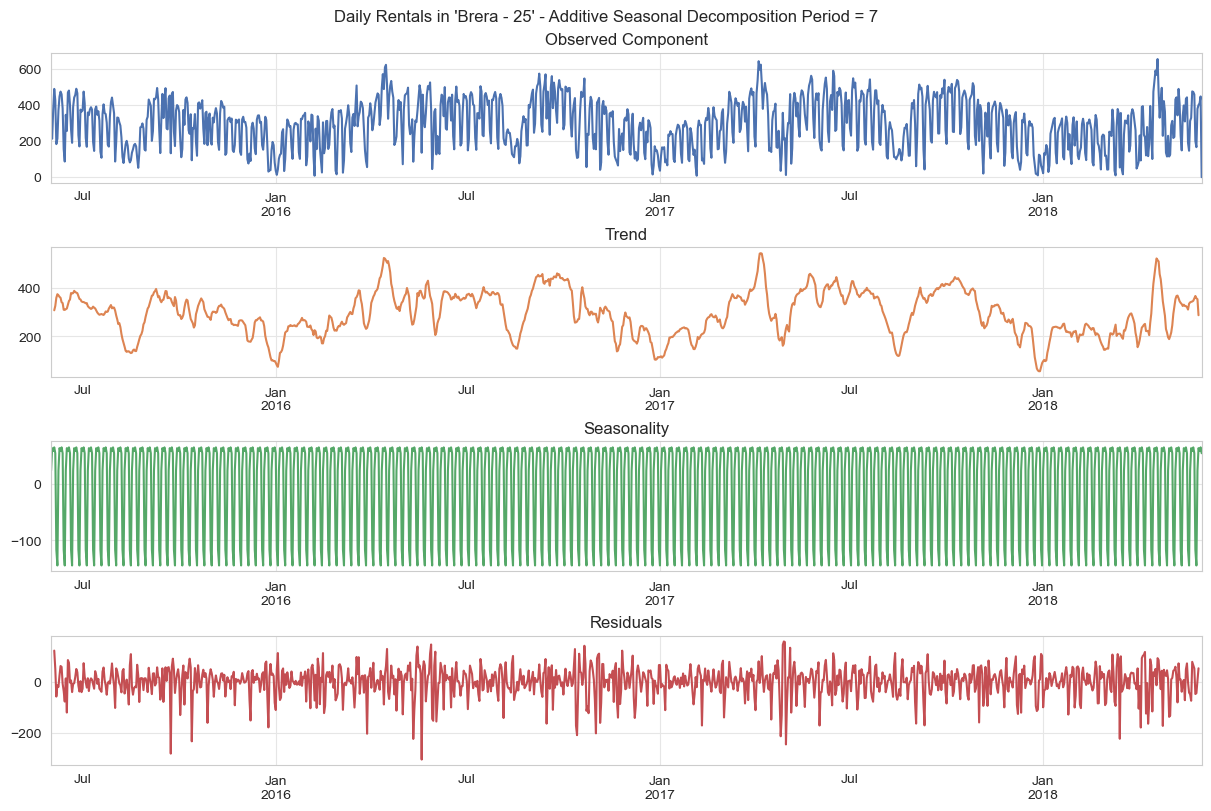

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


def build_plots(
        decomposed_series,
        series_name: str,
        decomposer_name: str,
        _palette
) -> None:
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), constrained_layout=True)

    decomposed_series.observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title="Observed Component", xlabel="")

    decomposed_series.trend.plot(c=_palette[1], ax=ax[1])
    ax[1].set(title="Trend", xlabel="")

    decomposed_series.seasonal.plot(c=_palette[2], ax=ax[2])
    ax[2].set(title="Seasonality", xlabel="")

    decomposed_series.resid.plot(c=_palette[3], ax=ax[3])
    ax[3].set(title="Residuals", xlabel="")

    plt.suptitle(f"Daily Rentals in '{series_name}' - {decomposer_name.title()}")

    plt.show()


def decompose_series(
        data: pd.DataFrame,
        col: str,
        period: int,
        mode: Optional[str] = None,
        palette=sns.color_palette(palette="deep")
) -> None:
    if mode is None:
        _model: str = "additive"
    elif mode not in ["additive", "multiplicative", None]:
        raise ValueError("'mode' must either be 'additive' (default value) or 'multiplicative'")
    else:
        _model: str = mode

    decomposition = seasonal_decompose(
        x=data[col],
        model=_model,
        period=period
    )

    build_plots(decomposition, col, f"{_model} Seasonal Decomposition {period = }", palette)


daily_rentals.pipe(decompose_series, "Brera - 25", period=7)

From the observed component we can already spot the yearly patterns, which are outlined in the trended series. There are always two troughs: one in August and the other one during Christmas holidays and New Year's Eve. There peak is always reached in May (and is preceded by a small dip around April and Easter holidays). Other two small dips can be observed around Carnival, in February (which is slightly longer and shifted, compared to the rest of Italy) and perhaps around Labour's Day (May 1st) and the National Holiday on June 2nd. Then, the demand dips during the autumn too: at All Saint's day (between Halloween and November 1st) and the city's Patrons celebrations on December 9th (while December 8th is also a national holiday). This displays that predictable patterns such as holidays will indeed play a role in accruing the accuracy of the forecasts: after all, as outlined in the literature and from observing the patterns in the origin-destination matrix, docked bike-sharing services are strictly related to commuting patterns.

The overall series displays a growing trend from January to the peak in May, a plateau around June and July, then the great August dip and a gradual declining trend from September to the end of the year. These yearly patterns are basically the biggest sources of variation, and are what we aim to capture with daily aggregated data. The residuals appear clearly heteroskedastic, but perhaps stationary. The residual variance increases around April and October-November: we might guesstimate it is due to weather and rain conditions.

It is also worth noting the scales: seasonalities scales are very much in the negative range (on average, the seasonal decomposition sums up to 0), but is as much as half the range of values for residuals. It seems clear that this decomposition does not do a great job, as the unexplained component is much large.

As an exercise, we can change the `period` of the data 30 days, as an exercise. This returns a much different seasonal pattern, which, however, is even less informative: the range of values is up to ten time smaller than the residuals. This also returns a much smoother linear trend, where the dips are less pronounced.

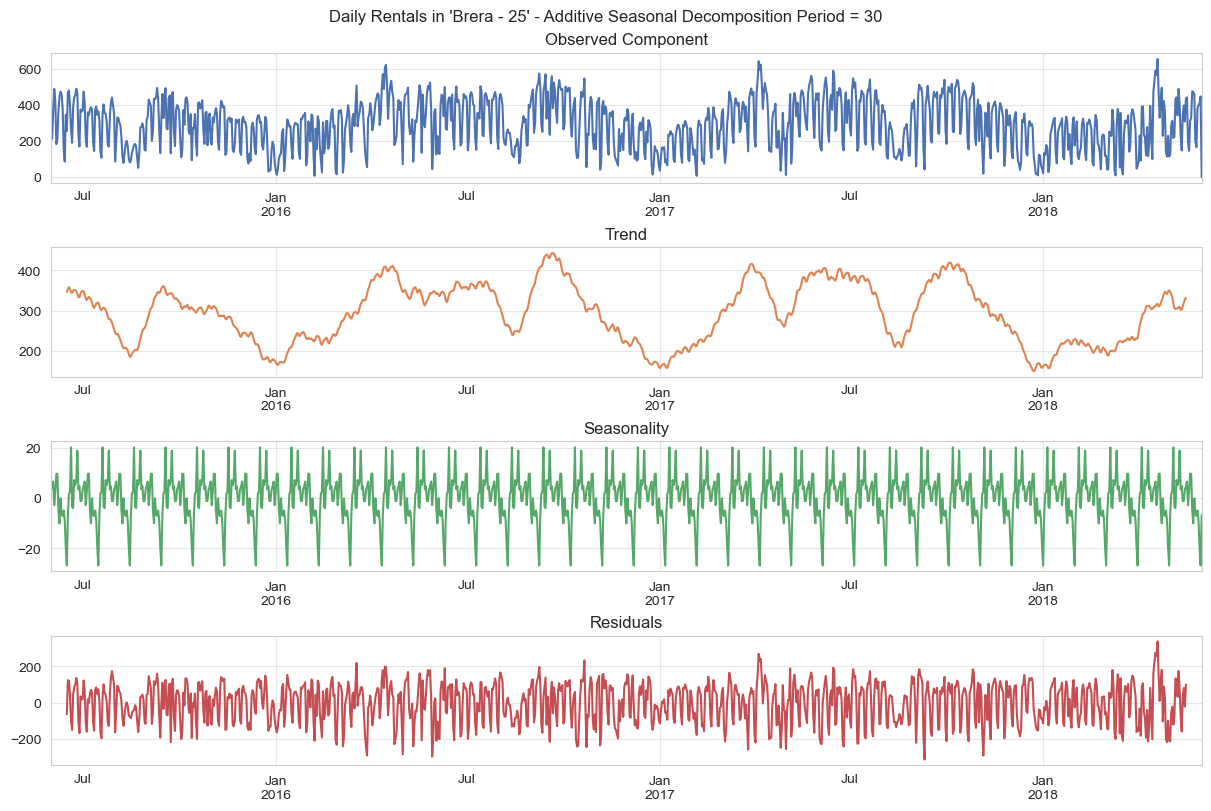

In [10]:
daily_rentals.pipe(decompose_series, "Brera - 25", period=30)

### Advanced Decomposition

To investigate these patterns we can exploit more advanced decompostion patterns. Official tools are often developed by official bureaus, as seasonal decomposition is especially needed when dealing with monthly or quarterly data. Inside the European Union, the [official recommendation](https://ec.europa.eu/eurostat/cros/content/software-jdemetra_en) is the JDemetra+ software library. The US Census Bureau implemented the X-11 category of models, which also allow the seasonal component to vary over time and are robust to outliers and missing values. These models, however, are not suited for daily and weekly data points <cite id="9w2x6">(Hyndman &#38; Athanasopoulos, 2021)</cite>.

For this reason, another technique is frequently used: STL decomposition, or Seasonal Trend decomposition using LOESS, proposed by Cleveland and his coauthors <cite id="8uj4a">(Cleveland &#38; Devlin, 1988)</cite>. LOESS is an acronym that unpacks to Locally Estimated Scatterplot Smoothing (or Savitzky-Golay filter), that indicates a non-parametric regression that is locally fitted. Simply put, the LOESS fits multiple, even polynomial regressions, "in a moving fashion analogous to how a moving average is computed for a time series" <cite id="7m1hc">(Cleveland &#38; Devlin, 1988)</cite>. `statsmodels` implements the STL decomposition directly from the fortran library developed by Cleveland, and has a plethora of arguments to tweak. These can be split into three categories.

The main parameters are the following:

* `endog` is the data to be decomposed.
* `period` is the periodicity of the sequence. It is detected automatically if the data is provided as a Pandas `DataFrame`. For example, if the data is monthly, the period is 12. In our case, since the data is daily, the period will be 7.
* `seasonal` is the length of the seasonal smoother and is set to 7 by default.
* `trend` is the length of the trend smoother. Must be an *odd* integer. If not provided uses the smallest odd integer greater than 1.5 * `period` / (1 - 1.5 / `seasonal`)
* `low_pass` is the length of the low-pass filter used for each subseries. Must be an odd integer >=3. If not provided, uses the smallest odd integer greater than `period`.

What this implies is that with STL decomposition we have a much greater control over the length of each smoother: we can look for a monthly trend and weekly seasonalities, for instance.

Then come the degrees parameters, i.e. whether to use a constant or a constant and trend. `0` indicates that only the constant is used and `1` also uses the trend. These values can be set with the parameters `seasonal_degint`, `trend_degint` and `low_pass_degint`.

Lastly, there are the interpolation step parameters. Basically, they reduce the estimation time by interpolating values between an interval. If any `_interpolation` parameter is set to an integer greater than or equal to one, LOESS is used every number of points, while the skipped values are linearly interpolated. Interpolation can happen at the `seasonal`, `trend` and `low_pass` level.

The function also has a `robustbool` flag, indicating whether to use a weighted version that is robust to some forms of outliers.

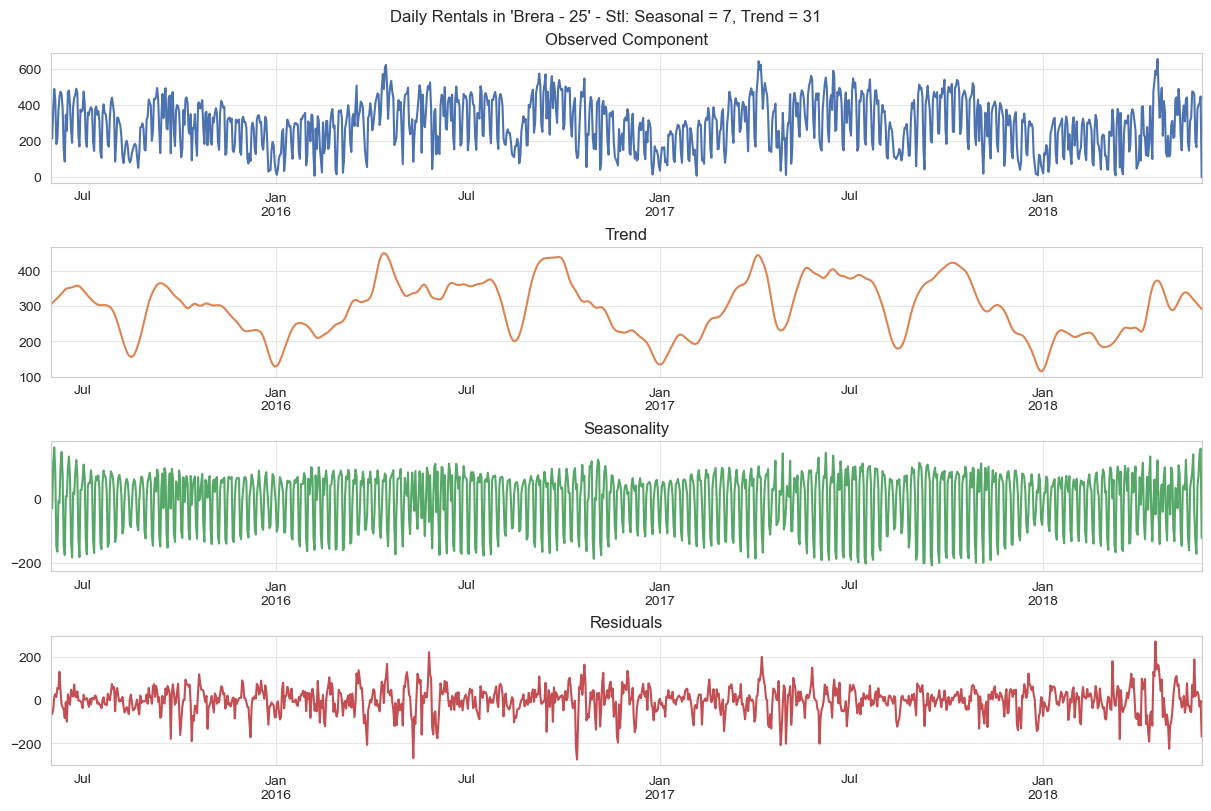

In [11]:
from statsmodels.tsa.seasonal import STL

stl_7 = STL(daily_rentals["Brera - 25"], period=7, seasonal=7, trend=31, seasonal_deg=1).fit()
build_plots(stl_7, "Brera - 25", f"STL: Seasonal = 7, Trend = 31", sns_c)

The STL decomposition fits a much smoother trend, which we set to `31` to capture the monthly variation. A higher figure, say yearly, would yield much smoother curves. It is immediate to notice that the seasonal patterns are dampened and vary across time quite significantly and display a much greater positive magnitude compared to the additive decomposition. Seasonal components shrink where the trend dips. The residuals also slightly improve: their variance becomes less hectic, because the STL better captures seasonality dynamics. However, high spikes remain.

## Correlation Analysis

Time series data is unique as the data points are not $i.i.d.$ distributed. In other words, even if we can assume that the data comes from the same distribution (i.e., is $i.d.$), independence is not present. Data points are correlated across time: hence the definition *auto-correlation*. To explore time-dependencies structure, the auto-correlation function (ACF) and partial auto-correlation function (PACF) are used. We denote the sample autocorrelation at lag $k$ by $r_k$

\begin{align}
&r_k = \frac{\sum_{t=k+1}^T (y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^T (y_t-\bar{y})^2}
\end{align}


However, the autocorrelation between to points at $k$ lags of distance might simply be due both points being connected by the same "chain" of intermediate values $y_{t-1}$ to $y_{t-(k+1)}$, rather than because of any new information contained in  $y_k$  that could be used to forecast $y_t$. This problem is solved via the PACF, which - simply put - estimates an autoregressive models (i.e., a linear regression fit only on the lags) and returns the coefficient of the $k$th component.

[]

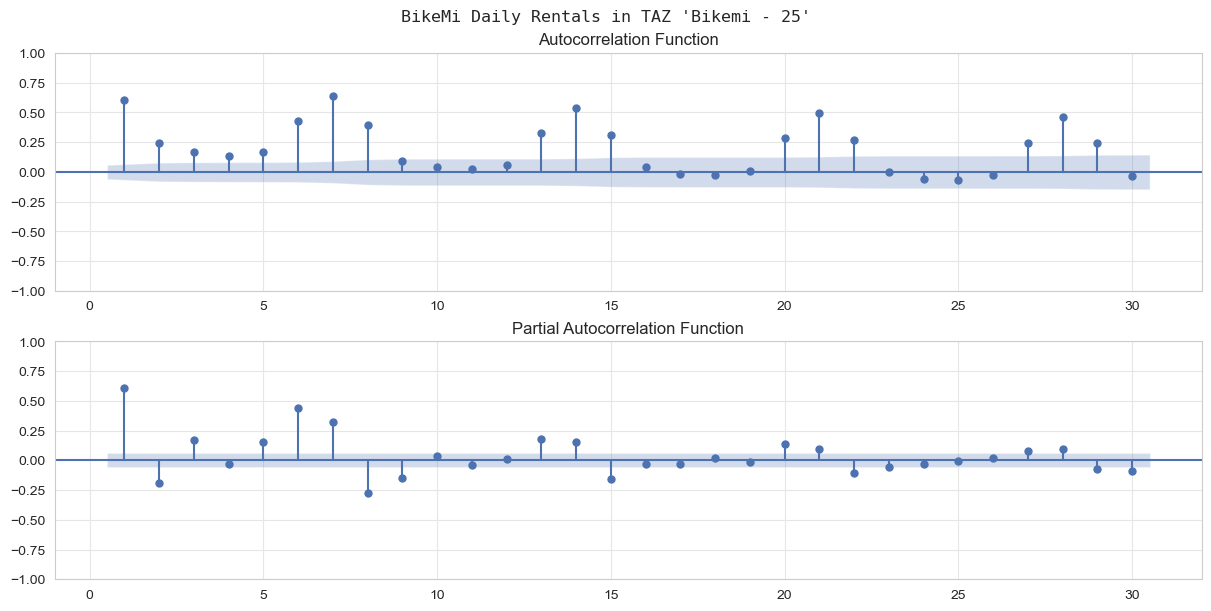

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, constrained_layout=True)
plot_acf(
    x=daily_rentals["Brera - 25"],
    lags=30,
    ax=ax[0],
    title="Autocorrelation Function",
    zero=False,
)
plot_pacf(
    x=daily_rentals["Brera - 25"],
    lags=30,
    ax=ax[1],
    title="Partial Autocorrelation Function",
    method="ywm",
    zero=False,
)

plt.suptitle("BikeMi Daily Rentals in TAZ 'Bikemi - 25'", **title_font)
plt.plot()

The plots indicate a strong auto-regressive component: basically all values in the week before are significant and the autocorrelations corresponding to the seasonal periodicities (approximately one week before) are all significant still one month later. The partial autocorrelation function drops to non-significant levels quite sooner but appear to still be significant around the seasonal components.

## Differencing

Differencing is the last step in our time series analysis. Given that the time series display seasonality, by definition they are non-stationary. Stationarity is a property that has two formulations. In its *strong* formulation, a time series $\{y_t\}$ is stationary if, for any $s$, the distribution of $(y_t,... y_{t+s})$ does not depend on $s$. This property is difficult to observe in economic terms - but can be observed in the realm of physics, like the swing of a (frictionless) pendulum: no matter the time, its properties like amplitude and period remain the same. For this reason, we settle with *weakly stationarity*, and time series that display this property are also called *wide-sense stationary*, *covariance stationary*, or *second order stationary* processes.

As the name suggests, these processes have first and second-order moments that are fixed in time; the same applies to auto-correlation, that should only depend on the length of the lag $k$, i.e. should be the same across any two time points at distance $k$. These two properties do not imply each other, unless when the underlying process is Gaussian. Our data does not seem unequivocably normal:

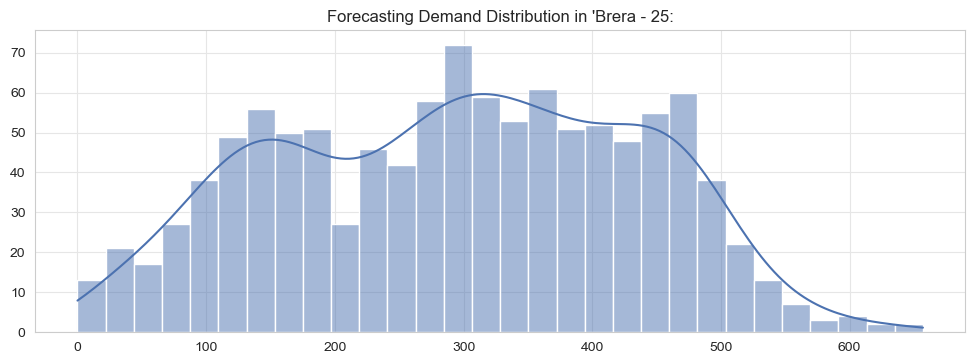

In [13]:
def plot_hist(
        data: pd.DataFrame,
        col: str,
        bins: Optional[int] = None,
        kde: bool = True,
        log: bool = False
) -> None:
    fig, ax = plt.subplots(figsize=(12, 4))

    if log:
        series = data[col].replace(0, 1).pipe(np.log)
    else:
        series = data[col]

    if not bins:
        bins = int(len(series) / 10)

    series.pipe(
        sns.histplot,
        ax=ax,
        kde=kde,
        bins=bins
    )

    ax.set(
        xlabel="",
        ylabel="",
        title=f"Forecasting Demand Distribution in '{col}:"
    )

    plt.show()


daily_rentals.pipe(plot_hist, "Brera - 25", bins=30)

To transform a non-stationary series into a (weakly) stationary one, the principal tool is taking differences, i.e. subtracting from every $y_t$ the $k$-th lagged value. Usually, however, the differences that are preferred are the ones that are interpretable: first differences represent the change between two observations, and the seasonal differences represent the increase from one seasonal period to the other (in this case, between two weeks).

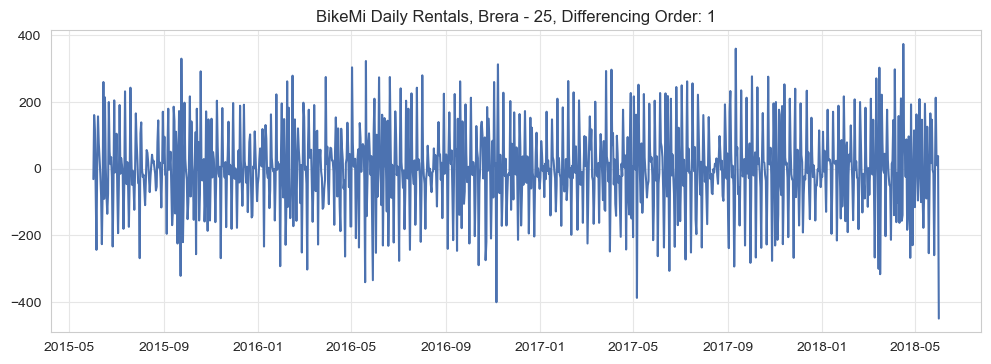

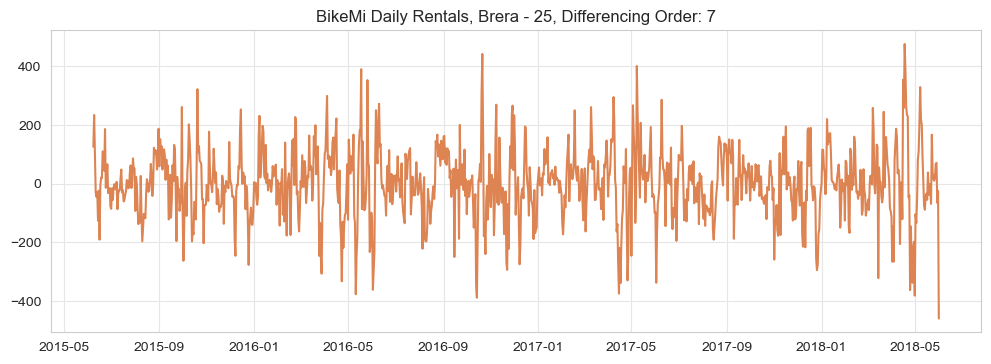

In [14]:
def plot_differences(data: pd.DataFrame, col: str, lag: int, color=sns.color_palette("deep")[0]) -> None:
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(data[col].diff(lag), c=color)
    ax.set(title=f"BikeMi Daily Rentals, {col}, Differencing Order: {lag}")

    plt.show()


plot_differences(daily_rentals, "Brera - 25", 1, color=sns_c[0])
plot_differences(daily_rentals, "Brera - 25", 7, color=sns_c[1])

First differencing returns seemingly stationary data, but the seasonal component is not removed. On the contrary, the seasonal differences are less noisy. Still, the two datasets display high variance, with a change as great as 400 observations. We can also difference the series twice; this, however, might not be recommendable if the series is already stationary after one round of differencing: "applying more differences than required will induce false dynamics or autocorrelations that do not really exist in the time series" <cite id="ixn54">(Hyndman &#38; Athanasopoulos, 2021)</cite>. At first glance, double differences seem to return a series that is more convincingly stationary.

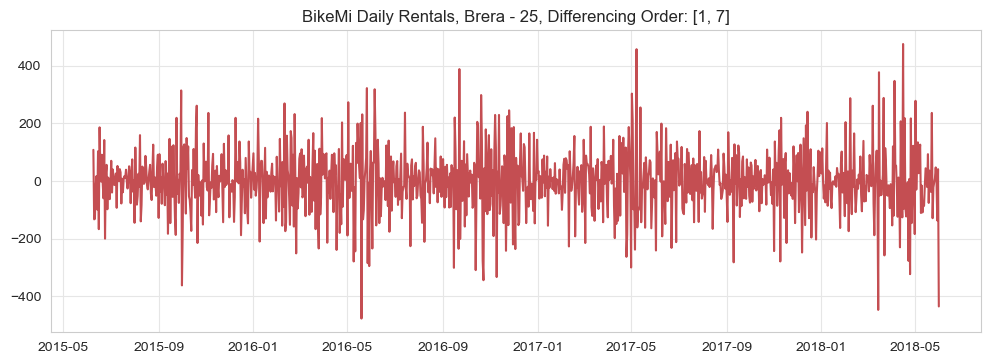

In [15]:
def plot_double_differences(data: pd.DataFrame, col: str, lag=None,
                            color=sns.color_palette("deep")[0]) -> None:
    if lag is None:
        lag = [1, 7]
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(data[col].diff(lag[0]).diff(lag[1]), c=color)
    ax.set(title=f"BikeMi Daily Rentals, {col}, Differencing Order: {lag}")

    plt.show()


plot_double_differences(daily_rentals, "Brera - 25", color=sns_c[3])

### Testing for Stationarity

Stationarity can be assessed more objectively using a particular category of statistical tests named *unit root tests*. Simply put,

One of the most popular unit root tests is the *Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test* <cite id="upeh9">(Kwiatkowski et al., 1992)</cite>. With the authors' words, the null hypothesis is that "an observable series is stationary around a deterministic trend", against the alternative that "the series is difference-stationary", i.e. requires differencing. In other words, the test's null hypothesis is that the process is level or trend stationary (i.e., does not exhibit a trend) and if we reject the null hypothesis (for $p$ values smaller than $0.05$) differencing is required.

Another test is the (Augmented) Dickey-Fuller or ADF test <cite id="mrcq5">(Dickey &#38; Fuller, 2012)</cite>. While the KPSS test's null hypothesis is that the series is already stationary, the ADF test assumes the opposite, i.e. the series is not stationary because it has a unit root. If we reject the null, we assume the time series to be stationary. Both tests suggest that data from `Brera - 25` is compatible with the hypothesis that the series is stationary, by taking either first order differences, seasonal differences (and the combination of both). For this reason, we shall stick to seasonal differences.

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss


def stationarity_test(lagged_series) -> None:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        adfuller_results = adfuller(
            # take seasonal diffs and drop the 7 missing values
            lagged_series.dropna(),
            regression="ct"
        )

        kpss_results = kpss(
            lagged_series.dropna(),
            regression="ct",
            nlags="auto"
        )

        console.print(
            f"ADF test statistic: {adfuller_results[0]:.3} ADF p-value: {adfuller_results[1]:.3%}:\n"
            f"{'there is no unit root - the series *is* stationary' if adfuller_results[1] < 0.05 else 'there is a unit root - the series *is not* stationary'}\n\n"
            f"KPSS test statistic: {kpss_results[0]:.3} KPSS p-value: {kpss_results[1]:.3%}:\n"
            f"{'there is a unit root - the series *is not* stationary' if kpss_results[1] < 0.05 else 'there is no unit root - the series *is* stationary'}"
        )


console.print("First Order Differences (Lag: 1)")
daily_rentals["Brera - 25"].diff(1).pipe(stationarity_test)
console.print("Seasonal Differences (Lag: 7)")
daily_rentals["Brera - 25"].diff(7).pipe(stationarity_test)
console.print("Double Differences (Lag: 7 and 1)")
daily_rentals["Brera - 25"].diff(7).diff(1).pipe(stationarity_test)

First Order Differences (Lag: 1)

ADF test statistic: -9.08 ADF p-value: 0.000%:
there is no unit root - the series *is* stationary

KPSS test statistic: 0.06 KPSS p-value: 10.000%:
there is no unit root - the series *is* stationary

Seasonal Differences (Lag: 7)

ADF test statistic: -7.9 ADF p-value: 0.000%:
there is no unit root - the series *is* stationary

KPSS test statistic: 0.012 KPSS p-value: 10.000%:
there is no unit root - the series *is* stationary

Double Differences (Lag: 7 and 1)

ADF test statistic: -12.5 ADF p-value: 0.000%:
there is no unit root - the series *is* stationary

KPSS test statistic: 0.0509 KPSS p-value: 10.000%:
there is no unit root - the series *is* stationary